In [22]:
import torch
import torch.nn as nn
import gensim
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.model_selection import train_test_split
import nltk
from tqdm import tqdm
import pymorphy2
from sklearn.metrics import accuracy_score

In [4]:
model_w2v = gensim.models.KeyedVectors.load_word2vec_format('E:\Programming\DL_CurseWork\embeding_weights.w2v')

In [6]:
dataset_tokens = pd.read_csv('E:\Programming\DL_CurseWork\dataset_mor.csv', index_col=0)

dataset_tokens['tokens'] = dataset_tokens['sents'].astype('str').map(lambda x: x.split())
dataset_tokens.head(2)

,sents,mark,tokens
0,обязательно посетить большой спасибо хозяйка г...,10,"[обязательно, посетить, большой, спасибо, хозя..."
1,приветливый берег приехать ребёнок семья ул . ...,3,"[приветливый, берег, приехать, ребёнок, семья,..."


In [7]:
dataset_tokens.shape

(3778, 3)

In [8]:
x_train, x_test, y_train, y_test = train_test_split(dataset_tokens['tokens'], dataset_tokens['mark'], test_size=0.2, random_state=268)

In [9]:
class ReviewDataset(Dataset):
  def __init__(self, X, y, vocab: gensim.models.KeyedVectors):
    self.X = X
    self.y = y
    self.vocab = vocab
    self.max_len = 500
    self.morth = pymorphy2.MorphAnalyzer()

  def vectorize(self, tokens):
    if type(tokens) == str: tokens = [self.morth.parse(w)[0].normal_form for w in nltk.word_tokenize(tokens.lower())]
    
    tokens = tokens if len(tokens) <= self.max_len else tokens[:self.max_len]
    
    if len(tokens) != self.max_len:
      tokens.extend(['.']*(self.max_len - len(tokens)))
    
    vec = torch.LongTensor([self.vocab.key_to_index[token] if token in self.vocab.key_to_index else 1 for token in tokens]).cuda()
    
    return vec
    
  def __len__(self):
    return len(self.X)

  def __getitem__(self, idx):
    
    y = 0
    if 6 < self.y.iloc[idx] <= 10: y = 1
    
    return self.vectorize(self.X.iloc[idx]), y

In [10]:
train_dataset = ReviewDataset(x_train, y_train, model_w2v)
test_dataset = ReviewDataset(x_test, y_test, model_w2v)

In [160]:
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=True)

In [183]:
class RatingNet(nn.Module):

  def __init__(self, embeding_m, hidden_size, n_classes):
    super(RatingNet, self).__init__()
    self.hidden_size = hidden_size
    self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(embeding_m.vectors).cuda())
    self.rnn = nn.RNN(300, hidden_size,batch_first=True).to('cuda:0')
    self.flat = nn.Flatten().to('cuda:0')
    self.fc = nn.Linear(in_features=hidden_size, out_features=n_classes).to('cuda:0')
    self.softmax = nn.Softmax()
  
  def forward(self, x):
    out = self.embedding(x)
    _, out = self.rnn(out)
    out = out.permute(1,0,2)
    out = self.flat(out)
    out = self.fc(out)
    return out


hidden = 64
n_classes = 2
model = RatingNet(embeding_m=model_w2v, hidden_size=hidden, n_classes=n_classes)
criterion = nn.CrossEntropyLoss(weight=torch.Tensor([2, 1]).cuda())
optimizer = optim.Adam(model.parameters(), lr=0.001)

torch.Size([8, 500, 300])


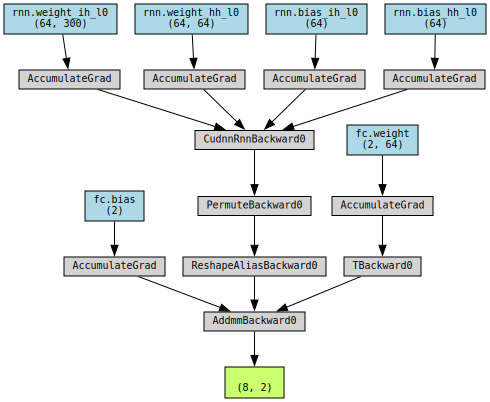

In [175]:
from torchviz import make_dot

make_dot(model(next(iter(train_loader))[0]), params=dict(model.named_parameters()))

In [194]:
from sklearn.metrics import accuracy_score

n_epochs = 50

history = []

for epoch in range(n_epochs):
  epoch_loss = 0
  for X_batch, y_batch in train_loader:
    predictions = model(X_batch.cuda())
    loss = criterion(predictions, y_batch.cuda()).cuda()
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    epoch_loss += loss.item()
  
  with torch.no_grad():
    val_loss, val_acc = 0, 0
    for X_batch, y_batch in test_loader:
      predictions = model(X_batch.cuda())
      loss = criterion(predictions, y_batch.cuda()).item()
      acc = accuracy_score(y_batch, predictions.argmax(dim=1).cpu().detach()).item()
      val_loss += loss
      val_acc += acc
    
    history.append(val_loss / len(test_loader))
    if epoch % 5 == 0:
      print(f'#{epoch} Training loss: {epoch_loss / len(train_loader)} val_loss: {val_loss / len(test_loader)}')

#0 Training loss: 0.6706932891140539 val_loss: 0.7168574929237366
#5 Training loss: 0.6716204188645832 val_loss: 0.7176806926727295
#10 Training loss: 0.6706694716972018 val_loss: 0.7268440127372742
#15 Training loss: 0.6722691507724227 val_loss: 0.719812273979187
#20 Training loss: 0.6729454219183594 val_loss: 0.7166316509246826
#25 Training loss: 0.6749555832021451 val_loss: 0.7693430185317993
#30 Training loss: 0.6729601609801489 val_loss: 0.7429118752479553
#35 Training loss: 0.6707326130419181 val_loss: 0.7166550159454346
#40 Training loss: 0.6731578946586639 val_loss: 0.7273474335670471
#45 Training loss: 0.6727726594323203 val_loss: 0.7385109663009644


Text(0.5, 1.0, 'Динамика ошибки модели RNN')

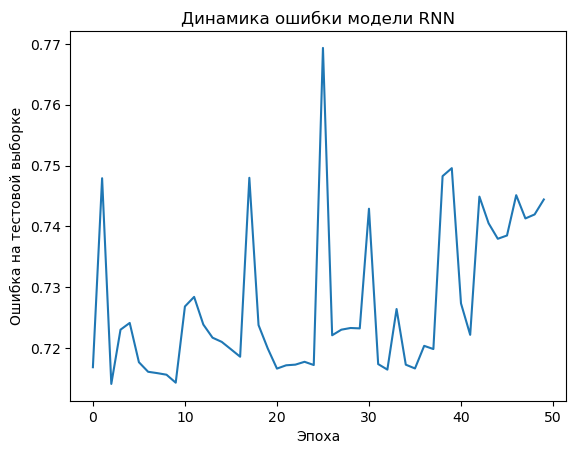

In [198]:
import matplotlib.pyplot as plt
plt.plot(history)
plt.xlabel('Эпоха')
plt.ylabel('Ошибка на тестовой выборке')
plt.title('Динамика ошибки модели RNN')

In [185]:
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=True)
X_batch, y_batch = next(iter(test_loader))
predictions = model(X_batch.cuda()).argmax(dim=1).cpu().detach()
print(classification_report(y_batch, predictions))

              precision    recall  f1-score   support

           0       0.39      0.99      0.56       295
           1       0.56      0.01      0.02       461

    accuracy                           0.39       756
   macro avg       0.47      0.50      0.29       756
weighted avg       0.49      0.39      0.23       756



In [208]:
class RatingNetV2(nn.Module):

  def __init__(self, embeding_m, hidden_size, n_classes):
    super(RatingNetV2, self).__init__()
    self.hidden_size = hidden_size
    self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(embeding_m.vectors).cuda())
    self.rnn = nn.RNN(300, hidden_size, num_layers=2, batch_first=True, dropout=0.4).to('cuda:0')
    self.flat = nn.Flatten().to('cuda:0')
    self.fc = nn.Linear(in_features=hidden_size*2, out_features=n_classes).to('cuda:0')
    self.softmax = nn.Softmax()
  
  def forward(self, x):
    out = self.embedding(x)
    _, out = self.rnn(out)
    out = out.permute(1,0,2)
    out = self.flat(out)
    out = self.fc(out)
    return out


hidden = 256
n_classes = 2
model = RatingNetV2(embeding_m=model_w2v, hidden_size=hidden, n_classes=n_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [209]:
from sklearn.metrics import accuracy_score

n_epochs = 50

history = []

for epoch in range(n_epochs):
  epoch_loss = 0
  for X_batch, y_batch in train_loader:
    predictions = model(X_batch.cuda())
    loss = criterion(predictions, y_batch.cuda()).cuda()
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    epoch_loss += loss.item()
  
  with torch.no_grad():
    val_loss, val_acc = 0, 0
    for X_batch, y_batch in test_loader:
      predictions = model(X_batch.cuda())
      loss = criterion(predictions, y_batch.cuda()).item()
      acc = accuracy_score(y_batch, predictions.argmax(dim=1).cpu().detach()).item()
      val_loss += loss
      val_acc += acc
    
    history.append(val_loss / len(test_loader))
    if epoch % 5 == 0:
      print(f'#{epoch} Training loss: {epoch_loss / len(train_loader)} val_loss: {val_loss / len(test_loader)}')

#0 Training loss: 0.7079287262032272 val_loss: 0.669529914855957
#5 Training loss: 0.6943701587656819 val_loss: 0.6822196245193481
#10 Training loss: 0.6852806555846381 val_loss: 0.6764397621154785
#15 Training loss: 0.6864562977558721 val_loss: 0.7634286880493164
#20 Training loss: 0.6802039379796023 val_loss: 0.6892499923706055
#25 Training loss: 0.6911227806771874 val_loss: 0.707795262336731
#30 Training loss: 0.6967849051826215 val_loss: 0.7007067799568176
#35 Training loss: 0.6786437888467123 val_loss: 0.8477637767791748
#40 Training loss: 0.6915426124182958 val_loss: 0.7738903164863586
#45 Training loss: 0.667553426727416 val_loss: 0.7043823003768921


Text(0.5, 1.0, 'Динамика ошибки модели RNN')

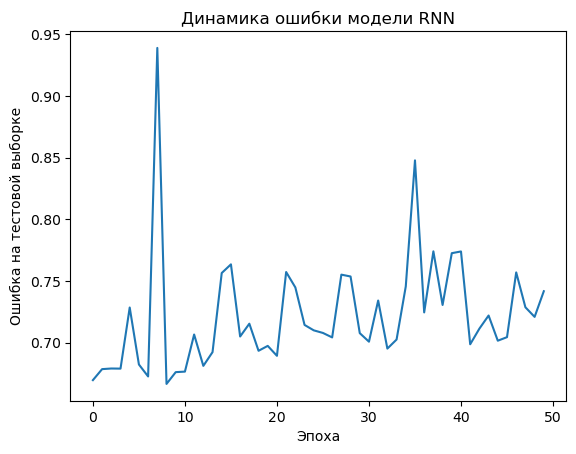

In [210]:
import matplotlib.pyplot as plt
plt.plot(history)
plt.xlabel('Эпоха')
plt.ylabel('Ошибка на тестовой выборке')
plt.title('Динамика ошибки модели RNN')

In [211]:
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=True)
X_batch, y_batch = next(iter(test_loader))
predictions = model(X_batch.cuda()).argmax(dim=1).cpu().detach()
print(classification_report(y_batch, predictions))

              precision    recall  f1-score   support

           0       0.55      0.02      0.04       295
           1       0.61      0.99      0.76       461

    accuracy                           0.61       756
   macro avg       0.58      0.50      0.40       756
weighted avg       0.59      0.61      0.48       756



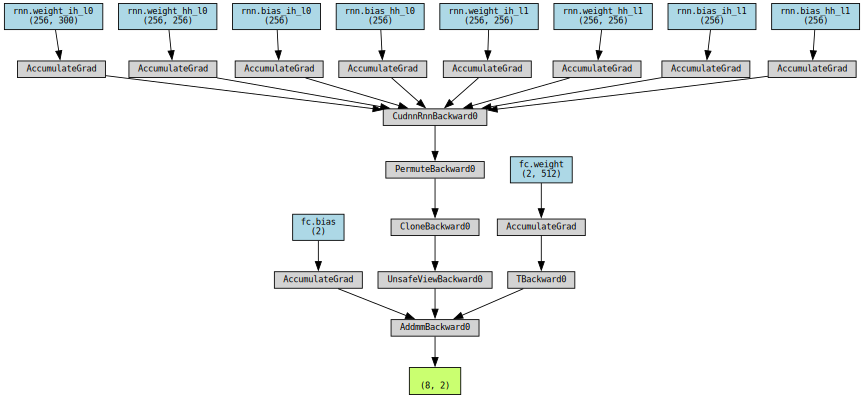

In [212]:
from torchviz import make_dot

make_dot(model(next(iter(train_loader))[0]), params=dict(model.named_parameters()))

In [214]:
class LSTMModel(nn.Module):
    
    def __init__(self, embeding_m, hidden_dim, output_dim, dropout):
        
        super().__init__()
        
        self.embedding  = nn.Embedding.from_pretrained(torch.FloatTensor(embeding_m.vectors).cuda())
        
        self.lstm = nn.LSTM(300, 
                            hidden_dim,
                            batch_first=True,
                            dropout=dropout)
        
        self.dropout = nn.Dropout(dropout)
        
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        x = self.dropout(self.embedding(x))
        
        lstm_out, _ = self.lstm(x)
        
        x = lstm_out[:, -1, :]
        
        x = self.fc(x)
        
        return x
        
        

In [215]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True)

In [218]:
model = LSTMModel(
    embeding_m=model_w2v,
    hidden_dim=256,
    output_dim=2,
    dropout=0.4
)

optimizer = optim.Adam(model.parameters())

criterion = nn.CrossEntropyLoss()

model = model.to('cuda')
criterion = criterion.to('cuda')

model

C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


LSTMModel(
  (embedding): Embedding(16523, 300)
  (lstm): LSTM(300, 256, batch_first=True, dropout=0.4)
  (dropout): Dropout(p=0.4, inplace=False)
  (fc): Linear(in_features=256, out_features=2, bias=True)
)

In [ ]:
from torchviz import make_dot

make_dot(model(next(iter(train_loader))[0]), params=dict(model.named_parameters()))

In [219]:
n_epochs = 50 + 1

history = []

save = None

for epoch in range(n_epochs):
    model.train()
    epoch_loss = 0
    for X_batch, y_batch in train_loader:
        predictions = model(X_batch.cuda())
        loss = criterion(predictions, y_batch.cuda())
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        epoch_loss += loss.item()
    
    with torch.no_grad():
        val_loss, val_acc = 0, 0
        for X_batch, y_batch in test_loader:
            predictions = model(X_batch.cuda())
            loss = criterion(predictions, y_batch.cuda()).item()
            acc = accuracy_score(y_batch, predictions.argmax(dim=1).cpu().detach()).item()
            val_loss += loss
            val_acc += acc
      
    history.append(val_loss / len(test_loader))
    if epoch % 2 == 0:
      print(f'#{epoch} Training loss: {epoch_loss / len(train_loader)} val_loss: {val_loss / len(test_loader)}')
    
    

#0 Training loss: 0.6742252830475096 val_loss: 0.6686657294631004
#2 Training loss: 0.6630731280203219 val_loss: 0.6695619908471903
#4 Training loss: 0.6555353863529427 val_loss: 0.672660389294227
#6 Training loss: 0.6496923373489784 val_loss: 0.6867014393210411
#8 Training loss: 0.6512941263970875 val_loss: 0.67340487241745
#10 Training loss: 0.5802059476337735 val_loss: 0.7224913847943147
#12 Training loss: 0.5194549207334165 val_loss: 0.45877917980154354
#14 Training loss: 0.4242895198641 val_loss: 0.40380120494713384
#16 Training loss: 0.3418846541138553 val_loss: 0.3599982224404812
#18 Training loss: 0.3225045193518911 val_loss: 0.36259037248479825
#20 Training loss: 0.3069917577166091 val_loss: 0.3679224541410804
#22 Training loss: 0.27382063475393115 val_loss: 0.35539346917842823
#24 Training loss: 0.25651201073612484 val_loss: 0.3918691510334611
#26 Training loss: 0.22485252408675416 val_loss: 0.35415185739596683
#28 Training loss: 0.2190631237965097 val_loss: 0.311033130002518

In [220]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=True)
X_batch, y_batch = next(iter(test_loader))
predictions = model(X_batch.cuda()).argmax(dim=1).cpu().detach()
print(classification_report(y_batch, predictions))

              precision    recall  f1-score   support

           0       0.90      0.76      0.82       295
           1       0.86      0.94      0.90       461

    accuracy                           0.87       756
   macro avg       0.88      0.85      0.86       756
weighted avg       0.87      0.87      0.87       756



Text(0.5, 1.0, 'Динамика ошибки модели RNN')

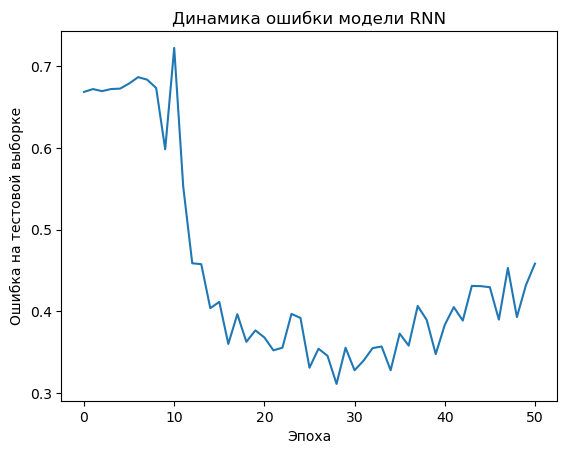

In [221]:
import matplotlib.pyplot as plt
plt.plot(history)
plt.xlabel('Эпоха')
plt.ylabel('Ошибка на тестовой выборке')
plt.title('Динамика ошибки модели RNN')

In [276]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=True)
X_batch, y_batch = next(iter(test_loader))
predictions = model(X_batch.cuda()).argmax(dim=1).cpu().detach()
print(confusion_matrix(y_batch, predictions))

[[269  26]
 [ 79 382]]


In [277]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=True)
X_batch, y_batch = next(iter(test_loader))
predictions = model(X_batch.cuda()).argmax(dim=1).cpu().detach()
print(roc_auc_score(y_batch, predictions))

0.8670612890179786


In [278]:
review = 'Отдых ужасный'
x = train_dataset.vectorize(review).unsqueeze(0)
predictions = model(x).argmax(dim=1).cpu().detach()
print(predictions)

tensor([0])


In [279]:
review = 'В сочи было очень хорошо. Приветливый персонал'
x = train_dataset.vectorize(review).unsqueeze(0)
predictions = model(x).argmax(dim=1).cpu().detach()
print(predictions)


tensor([1])


In [280]:
review = 'Было очень грязно'
x = train_dataset.vectorize(review).unsqueeze(0)
predictions = model(x).argmax(dim=1).cpu().detach()
print(predictions)

tensor([0])


In [285]:
review = 'отзыв о кафе грейс: К сожалению, наш поход в данное заведение нам совершенно не понравился. Уже с самого начала все незаладилось, после того, как нас 20 минут не могли посадить и еще столько же принять заказ. Прождав 30 минут, мы сами взяли кофе со стойки и шарлотку, которая оказалась сухой. Единственное, нужно отдать должное менеджер пытался координировать персонал, но это особо не помогало. Организации абсолютно не было, что испортило наш визит'
x = train_dataset.vectorize(review).unsqueeze(0)
predictions = model(x).argmax(dim=1).cpu().detach()
print(predictions)

tensor([0])


In [15]:
from ray import air, tune
from ray.air import session
from ray.tune.schedulers import ASHAScheduler

In [36]:
def train_lstm(config):
    train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=config['batch_size'], shuffle=True)
    
    model = LSTMModel(
        embeding_m=model_w2v,
        hidden_dim=config['hidden_dim'],
        output_dim=2,
        n_layers=2,
        dropout=config['dropout']
    )
    
    model = model.to('cuda')
    
    optimizer = optim.Adam(model.parameters())
    criterion = nn.CrossEntropyLoss()
    
    criterion = criterion.to('cuda')

    for epoch in range(config['epoch_number']):
        model.train()
        epoch_loss = 0
        for X_batch, y_batch in train_loader:
            predictions = model(X_batch.cuda())
            loss = criterion(predictions, y_batch.cuda())
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            epoch_loss += loss.item()
        
        with torch.no_grad():
            val_loss, val_acc = 0, 0
            for X_batch, y_batch in test_loader:
                predictions = model(X_batch.cuda())
                loss = criterion(predictions, y_batch.cuda()).item()
                acc = accuracy_score(y_batch, predictions.argmax(dim=1).cpu().detach()).item()
                val_loss += loss
                val_acc += acc
        
        
        
        session.report({"val_loss": val_loss / len(test_loader)})
        
        if epoch % 5 == 0:
            # This saves the model to the trial directory
            print(f'{config.items()}. {val_loss / len(test_loader)}')
            torch.save(model.state_dict(), "E:/Programming/DL_CurseWork/models/model.pth")
            
        

In [37]:
search_space = {
    'batch_size': tune.grid_search([16, 32]),
    'hidden_dim': tune.grid_search([256, 512]),
    'dropout': tune.grid_search([0.2, 0.3, 0.4, 0.5, 0.6, 0.7]),
    'epoch_number': tune.grid_search([25, 35, 45, 60])
}

In [38]:

train_model = tune.with_resources(train_lstm, {"cpu": 6, 'gpu': 1})

tuner = tune.Tuner(
    train_model,
    tune_config=tune.TuneConfig(
        num_samples=10,
        scheduler=ASHAScheduler(metric="val_loss", mode="max"),
    ),
    param_space=search_space,
)

results = tuner.fit()

2023-04-30 21:16:10,864	WARNING worker.py:1986 -- Warning: The actor ImplicitFunc is very large (27 MiB). Check that its definition is not implicitly capturing a large array or other object in scope. Tip: use ray.put() to put large objects in the Ray object store.
2023-04-30 21:16:10,962	WARNING util.py:244 -- The `start_trial` operation took 1.634 s, which may be a performance bottleneck.
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "


Trial name,date,done,hostname,iterations_since_restore,node_ip,pid,time_since_restore,time_this_iter_s,time_total_s,timestamp,training_iteration,trial_id,val_loss
train_lstm_079c0_00000,2023-04-30_21-19-15,False,DESKTOP-F7DMKF0,24,127.0.0.1,18488,174.113,7.16799,174.113,1682878755,24,079c0_00000,0.410266


(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 256), ('dropout', 0.2), ('epoch_number', 25)]). 0.6682854580382506
(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 256), ('dropout', 0.2), ('epoch_number', 25)]). 0.6773765409986178
(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 256), ('dropout', 0.2), ('epoch_number', 25)]). 0.4245818741619587
(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 256), ('dropout', 0.2), ('epoch_number', 25)]). 0.40856688112641376
(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 256), ('dropout', 0.2), ('epoch_number', 25)]). 0.4238090000580996


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "


(train_lstm pid=18488) dict_items([('batch_size', 32), ('hidden_dim', 256), ('dropout', 0.2), ('epoch_number', 25)]). 0.6688832491636276
(train_lstm pid=18488) dict_items([('batch_size', 32), ('hidden_dim', 256), ('dropout', 0.2), ('epoch_number', 25)]). 0.6783007631699244
(train_lstm pid=18488) dict_items([('batch_size', 32), ('hidden_dim', 256), ('dropout', 0.2), ('epoch_number', 25)]). 0.696622408926487
(train_lstm pid=18488) dict_items([('batch_size', 32), ('hidden_dim', 256), ('dropout', 0.2), ('epoch_number', 25)]). 0.6850846310456594
(train_lstm pid=18488) dict_items([('batch_size', 32), ('hidden_dim', 256), ('dropout', 0.2), ('epoch_number', 25)]). 0.6826977531115214


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "


(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 256), ('dropout', 0.3), ('epoch_number', 25)]). 0.670781875650088
(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 256), ('dropout', 0.3), ('epoch_number', 25)]). 0.6864930416146914
(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 256), ('dropout', 0.3), ('epoch_number', 25)]). 0.42476089764386415


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
(train_lstm pid=18488)   warni

(train_lstm pid=18488) dict_items([('batch_size', 32), ('hidden_dim', 256), ('dropout', 0.5), ('epoch_number', 25)]). 0.6710209026932716


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "


(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 256), ('dropout', 0.6), ('epoch_number', 25)]). 0.6739402245730162


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "


(train_lstm pid=18488) dict_items([('batch_size', 32), ('hidden_dim', 256), ('dropout', 0.6), ('epoch_number', 25)]). 0.6725913658738136


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.7 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.7 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "


(train_lstm pid=18488) dict_items([('batch_size', 32), ('hidden_dim', 256), ('dropout', 0.2), ('epoch_number', 35)]). 0.671551525592804
(train_lstm pid=18488) dict_items([('batch_size', 32), ('hidden_dim', 256), ('dropout', 0.2), ('epoch_number', 35)]). 0.6720385774970055
(train_lstm pid=18488) dict_items([('batch_size', 32), ('hidden_dim', 256), ('dropout', 0.2), ('epoch_number', 35)]). 0.6803241496284803
(train_lstm pid=18488) dict_items([('batch_size', 32), ('hidden_dim', 256), ('dropout', 0.2), ('epoch_number', 35)]). 0.6826434110601743
(train_lstm pid=18488) dict_items([('batch_size', 32), ('hidden_dim', 256), ('dropout', 0.2), ('epoch_number', 35)]). 0.38013903858760995
(train_lstm pid=18488) dict_items([('batch_size', 32), ('hidden_dim', 256), ('dropout', 0.2), ('epoch_number', 35)]). 0.3695850223302841
(train_lstm pid=18488) dict_items([('batch_size', 32), ('hidden_dim', 256), ('dropout', 0.2), ('epoch_number', 35)]). 0.43822718132287264


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
(train_lstm pid=18488)   warni

(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 256), ('dropout', 0.4), ('epoch_number', 35)]). 0.6713687665760517
(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 256), ('dropout', 0.4), ('epoch_number', 35)]). 0.6680118292570114
(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 256), ('dropout', 0.4), ('epoch_number', 35)]). 0.4511464911823471


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "


(train_lstm pid=18488) dict_items([('batch_size', 32), ('hidden_dim', 256), ('dropout', 0.4), ('epoch_number', 35)]). 0.6745492468277613


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "


(train_lstm pid=18488) dict_items([('batch_size', 32), ('hidden_dim', 256), ('dropout', 0.5), ('epoch_number', 35)]). 0.6753064095973969


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.7 and num_layers=1
(train_lstm pid=18488)   warni

(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 256), ('dropout', 0.7), ('epoch_number', 35)]). 0.6717548407614231


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.7 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "


(train_lstm pid=18488) dict_items([('batch_size', 32), ('hidden_dim', 256), ('dropout', 0.7), ('epoch_number', 35)]). 0.6766131445765495


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "


(train_lstm pid=18488) dict_items([('batch_size', 32), ('hidden_dim', 256), ('dropout', 0.2), ('epoch_number', 45)]). 0.6719746043284734


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
(train_lstm pid=18488)   warni

(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 256), ('dropout', 0.7), ('epoch_number', 45)]). 0.6728250359495481


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.7 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "


(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 256), ('dropout', 0.2), ('epoch_number', 60)]). 0.6743100397288799
(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 256), ('dropout', 0.2), ('epoch_number', 60)]). 0.6823292076587677
(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 256), ('dropout', 0.2), ('epoch_number', 60)]). 0.6936916174987952
(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 256), ('dropout', 0.2), ('epoch_number', 60)]). 0.6897871221105257
(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 256), ('dropout', 0.2), ('epoch_number', 60)]). 0.7022280332942804
(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 256), ('dropout', 0.2), ('epoch_number', 60)]). 0.49653980943063897
(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 256), ('dropout', 0.2), ('epoch_number', 60)]). 0.4578261288503806
(train_lstm pid=18488) dict_items([('bat

(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
(train_lstm pid=18488)   warni

(train_lstm pid=18488) dict_items([('batch_size', 32), ('hidden_dim', 256), ('dropout', 0.5), ('epoch_number', 60)]). 0.6714886774619421


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "


(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 256), ('dropout', 0.6), ('epoch_number', 60)]). 0.675245085110267


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "


(train_lstm pid=18488) dict_items([('batch_size', 32), ('hidden_dim', 256), ('dropout', 0.6), ('epoch_number', 60)]). 0.6747861181696256


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.7 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.7 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
(train_lstm pid=18488)   warni

(train_lstm pid=18488) dict_items([('batch_size', 32), ('hidden_dim', 512), ('dropout', 0.4), ('epoch_number', 25)]). 0.6719245538115501


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6 and num_layers=1
(train_lstm pid=18488)   warni

(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.7), ('epoch_number', 25)]). 0.673639565706253
(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.7), ('epoch_number', 25)]). 0.6954590280850729
(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.7), ('epoch_number', 25)]). 0.673108734190464


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.7 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
(train_lstm pid=18488)   warni

(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.5), ('epoch_number', 35)]). 0.6728511191904545
(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.5), ('epoch_number', 35)]). 0.6800628503163656
(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.5), ('epoch_number', 35)]). 0.6990766848127047
(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.5), ('epoch_number', 35)]). 0.7065256188313166
(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.5), ('epoch_number', 35)]). 0.7053140625357628
(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.5), ('epoch_number', 35)]). 0.6799190106491247
(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.5), ('epoch_number', 35)]). 0.7023341295619806


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "


(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.6), ('epoch_number', 35)]). 0.6720494826634725


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.7 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "


(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.7), ('epoch_number', 35)]). 0.6725088966389497


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.7 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
(train_lstm pid=18488)   warni

(train_lstm pid=18488) dict_items([('batch_size', 32), ('hidden_dim', 512), ('dropout', 0.3), ('epoch_number', 45)]). 0.6744880278905233
(train_lstm pid=18488) dict_items([('batch_size', 32), ('hidden_dim', 512), ('dropout', 0.3), ('epoch_number', 45)]). 0.6857210273543993
(train_lstm pid=18488) dict_items([('batch_size', 32), ('hidden_dim', 512), ('dropout', 0.3), ('epoch_number', 45)]). 0.6892347782850266
(train_lstm pid=18488) dict_items([('batch_size', 32), ('hidden_dim', 512), ('dropout', 0.3), ('epoch_number', 45)]). 0.686477410296599
(train_lstm pid=18488) dict_items([('batch_size', 32), ('hidden_dim', 512), ('dropout', 0.3), ('epoch_number', 45)]). 0.6900799348950386
(train_lstm pid=18488) dict_items([('batch_size', 32), ('hidden_dim', 512), ('dropout', 0.3), ('epoch_number', 45)]). 0.6865226303537687
(train_lstm pid=18488) dict_items([('batch_size', 32), ('hidden_dim', 512), ('dropout', 0.3), ('epoch_number', 45)]). 0.6932165200511614
(train_lstm pid=18488) dict_items([('batch

(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "


(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.4), ('epoch_number', 45)]). 0.679651539772749
(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.4), ('epoch_number', 45)]). 0.6754344763855139
(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.4), ('epoch_number', 45)]). 0.6870071093241373


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6 and num_layers=1
(train_lstm pid=18488)   warni

(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.6), ('epoch_number', 45)]). 0.6759627343465885


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.7 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "


(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.7), ('epoch_number', 45)]). 0.6781079235176245
(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.7), ('epoch_number', 45)]). 0.6660336516797543
(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.7), ('epoch_number', 45)]). 0.688566525777181


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.7 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "


(train_lstm pid=18488) dict_items([('batch_size', 32), ('hidden_dim', 512), ('dropout', 0.7), ('epoch_number', 45)]). 0.6723254323005676


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "


(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.2), ('epoch_number', 60)]). 0.6756831755240759


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
(train_lstm pid=18488)   warni

(train_lstm pid=18488) dict_items([('batch_size', 32), ('hidden_dim', 512), ('dropout', 0.6), ('epoch_number', 60)]). 0.6737943862875303


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.7 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "


(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.7), ('epoch_number', 60)]). 0.6726481678585211


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.7 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
(train_lstm pid=18488)   warni

(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 256), ('dropout', 0.4), ('epoch_number', 25)]). 0.672376765559117


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "


(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 256), ('dropout', 0.5), ('epoch_number', 25)]). 0.673516129453977


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "


(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 256), ('dropout', 0.6), ('epoch_number', 25)]). 0.677398386100928


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "


(train_lstm pid=18488) dict_items([('batch_size', 32), ('hidden_dim', 256), ('dropout', 0.6), ('epoch_number', 25)]). 0.6748431225617727


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.7 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.7 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
(train_lstm pid=18488)   warni

(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 256), ('dropout', 0.7), ('epoch_number', 35)]). 0.6727961786091328


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.7 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
(train_lstm pid=18488)   warni

(train_lstm pid=18488) dict_items([('batch_size', 32), ('hidden_dim', 256), ('dropout', 0.4), ('epoch_number', 45)]). 0.6745848879218102


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6 and num_layers=1
(train_lstm pid=18488)   warni

(train_lstm pid=18488) dict_items([('batch_size', 32), ('hidden_dim', 256), ('dropout', 0.7), ('epoch_number', 45)]). 0.6800306091705958


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
(train_lstm pid=18488)   warni

(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 256), ('dropout', 0.4), ('epoch_number', 60)]). 0.6726864986121655


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
(train_lstm pid=18488)   warni

(train_lstm pid=18488) dict_items([('batch_size', 32), ('hidden_dim', 256), ('dropout', 0.5), ('epoch_number', 60)]). 0.6755105207363764


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "


(train_lstm pid=18488) dict_items([('batch_size', 32), ('hidden_dim', 256), ('dropout', 0.6), ('epoch_number', 60)]). 0.6768239426116148


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.7 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.7 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "


(train_lstm pid=18488) dict_items([('batch_size', 32), ('hidden_dim', 256), ('dropout', 0.7), ('epoch_number', 60)]). 0.6723650172352791
(train_lstm pid=18488) dict_items([('batch_size', 32), ('hidden_dim', 256), ('dropout', 0.7), ('epoch_number', 60)]). 0.6726211781303088
(train_lstm pid=18488) dict_items([('batch_size', 32), ('hidden_dim', 256), ('dropout', 0.7), ('epoch_number', 60)]). 0.6725336189071337


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
(train_lstm pid=18488)   warni

(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.3), ('epoch_number', 25)]). 0.6773688544829687
(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.3), ('epoch_number', 25)]). 0.6723509455720583
(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.3), ('epoch_number', 25)]). 0.6884095172087351


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
(train_lstm pid=18488)   warni

(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.5), ('epoch_number', 25)]). 0.6771878680835167
(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.5), ('epoch_number', 25)]). 0.6870994530618191
(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.5), ('epoch_number', 25)]). 0.6884533849855264
(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.5), ('epoch_number', 25)]). 0.7023798314233621
(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.5), ('epoch_number', 25)]). 0.3989616804756224


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6 and num_layers=1
(train_lstm pid=18488)   warni

(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.2), ('epoch_number', 35)]). 0.6739305655161539
(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.2), ('epoch_number', 35)]). 0.6893106885254383
(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.2), ('epoch_number', 35)]). 0.6923197644452254
(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.2), ('epoch_number', 35)]). 0.7014889232814312
(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.2), ('epoch_number', 35)]). 0.6922036583224932
(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.2), ('epoch_number', 35)]). 0.6987491759161154
(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.2), ('epoch_number', 35)]). 0.690268707772096


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
(train_lstm pid=18488)   warni

(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.6), ('epoch_number', 35)]). 0.6721025655666987


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.7 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.7 and num_layers=1
(train_lstm pid=18488)   warni

(train_lstm pid=18488) dict_items([('batch_size', 32), ('hidden_dim', 512), ('dropout', 0.2), ('epoch_number', 45)]). 0.6725922475258509
(train_lstm pid=18488) dict_items([('batch_size', 32), ('hidden_dim', 512), ('dropout', 0.2), ('epoch_number', 45)]). 0.6741466820240021
(train_lstm pid=18488) dict_items([('batch_size', 32), ('hidden_dim', 512), ('dropout', 0.2), ('epoch_number', 45)]). 0.681528868774573


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
(train_lstm pid=18488)   warni

(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "


(train_lstm pid=18488) dict_items([('batch_size', 32), ('hidden_dim', 512), ('dropout', 0.5), ('epoch_number', 45)]). 0.6746062089999517
(train_lstm pid=18488) dict_items([('batch_size', 32), ('hidden_dim', 512), ('dropout', 0.5), ('epoch_number', 45)]). 0.6757660433650017
(train_lstm pid=18488) dict_items([('batch_size', 32), ('hidden_dim', 512), ('dropout', 0.5), ('epoch_number', 45)]). 0.6805666834115982
(train_lstm pid=18488) dict_items([('batch_size', 32), ('hidden_dim', 512), ('dropout', 0.5), ('epoch_number', 45)]). 0.691172237197558
(train_lstm pid=18488) dict_items([('batch_size', 32), ('hidden_dim', 512), ('dropout', 0.5), ('epoch_number', 45)]). 0.694062240421772
(train_lstm pid=18488) dict_items([('batch_size', 32), ('hidden_dim', 512), ('dropout', 0.5), ('epoch_number', 45)]). 0.6991304953893026
(train_lstm pid=18488) dict_items([('batch_size', 32), ('hidden_dim', 512), ('dropout', 0.5), ('epoch_number', 45)]). 0.7112579445044199
(train_lstm pid=18488) dict_items([('batch_

(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "


(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.6), ('epoch_number', 45)]). 0.6873210749278466


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.7 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.7 and num_layers=1
(train_lstm pid=18488)   warni

(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.3), ('epoch_number', 60)]). 0.6742036206026872


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
(train_lstm pid=18488)   warni

(train_lstm pid=18488) dict_items([('batch_size', 32), ('hidden_dim', 512), ('dropout', 0.4), ('epoch_number', 60)]). 0.6750397756695747


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "


(train_lstm pid=18488) dict_items([('batch_size', 32), ('hidden_dim', 512), ('dropout', 0.5), ('epoch_number', 60)]). 0.675673745572567


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.7 and num_layers=1
(train_lstm pid=18488)   warni

(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
(train_lstm pid=18488)   warni

(train_lstm pid=18488) dict_items([('batch_size', 32), ('hidden_dim', 256), ('dropout', 0.5), ('epoch_number', 25)]). 0.6748793621857961


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.7 and num_layers=1
(train_lstm pid=18488)   warni

(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 256), ('dropout', 0.7), ('epoch_number', 25)]). 0.6725072202583154


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.7 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
(train_lstm pid=18488)   warni

(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "


(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 256), ('dropout', 0.5), ('epoch_number', 35)]). 0.6734599980215231


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "


(train_lstm pid=18488) dict_items([('batch_size', 32), ('hidden_dim', 256), ('dropout', 0.5), ('epoch_number', 35)]). 0.6744211663802465


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.7 and num_layers=1
(train_lstm pid=18488)   warni

(train_lstm pid=18488) dict_items([('batch_size', 32), ('hidden_dim', 256), ('dropout', 0.4), ('epoch_number', 45)]). 0.6824101482828459


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6 and num_layers=1
(train_lstm pid=18488)   warni

(train_lstm pid=18488) dict_items([('batch_size', 32), ('hidden_dim', 256), ('dropout', 0.6), ('epoch_number', 45)]). 0.6770008951425552


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.7 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.7 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "


(train_lstm pid=18488) dict_items([('batch_size', 32), ('hidden_dim', 256), ('dropout', 0.7), ('epoch_number', 45)]). 0.6720429708560308


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
(train_lstm pid=18488)   warni

(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 256), ('dropout', 0.3), ('epoch_number', 60)]). 0.6774404135843118
(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 256), ('dropout', 0.3), ('epoch_number', 60)]). 0.6766246072947979
(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 256), ('dropout', 0.3), ('epoch_number', 60)]). 0.6804179549217224


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
(train_lstm pid=18488)   warni

(train_lstm pid=18488) dict_items([('batch_size', 32), ('hidden_dim', 256), ('dropout', 0.4), ('epoch_number', 60)]). 0.6814435596267382


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6 and num_layers=1
(train_lstm pid=18488)   warni

(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
(train_lstm pid=18488)   warni

(train_lstm pid=18488) dict_items([('batch_size', 32), ('hidden_dim', 512), ('dropout', 0.4), ('epoch_number', 25)]). 0.675861082971096
(train_lstm pid=18488) dict_items([('batch_size', 32), ('hidden_dim', 512), ('dropout', 0.4), ('epoch_number', 25)]). 0.6675218790769577
(train_lstm pid=18488) dict_items([('batch_size', 32), ('hidden_dim', 512), ('dropout', 0.4), ('epoch_number', 25)]). 0.679592010875543


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6 and num_layers=1
(train_lstm pid=18488)   warni

(train_lstm pid=18488) dict_items([('batch_size', 32), ('hidden_dim', 512), ('dropout', 0.6), ('epoch_number', 25)]). 0.6727553034822146


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.7 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "


(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.7), ('epoch_number', 25)]). 0.6784905356665453


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.7 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
(train_lstm pid=18488)   warni

(train_lstm pid=18488) dict_items([('batch_size', 32), ('hidden_dim', 512), ('dropout', 0.7), ('epoch_number', 35)]). 0.6752153088649114
(train_lstm pid=18488) dict_items([('batch_size', 32), ('hidden_dim', 512), ('dropout', 0.7), ('epoch_number', 35)]). 0.6737239683667818
(train_lstm pid=18488) dict_items([('batch_size', 32), ('hidden_dim', 512), ('dropout', 0.7), ('epoch_number', 35)]). 0.6681781634688377


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "


(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.2), ('epoch_number', 45)]). 0.6758661593000094
(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.2), ('epoch_number', 45)]). 0.6823729487756888
(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.2), ('epoch_number', 45)]). 0.6857565927008787


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
(train_lstm pid=18488)   warni

(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.5), ('epoch_number', 45)]). 0.6731578422089418
(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.5), ('epoch_number', 45)]). 0.6879654613633951
(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.5), ('epoch_number', 45)]). 0.4538640493216614


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "


(train_lstm pid=18488) dict_items([('batch_size', 32), ('hidden_dim', 512), ('dropout', 0.5), ('epoch_number', 45)]). 0.6732804129521052


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.7 and num_layers=1
(train_lstm pid=18488)   warni

(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.7), ('epoch_number', 45)]). 0.6784379010399183


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.7 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "


(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.2), ('epoch_number', 60)]). 0.6856923885643482


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
(train_lstm pid=18488)   warni

(train_lstm pid=18488) dict_items([('batch_size', 32), ('hidden_dim', 512), ('dropout', 0.3), ('epoch_number', 60)]). 0.6739849150180817
(train_lstm pid=18488) dict_items([('batch_size', 32), ('hidden_dim', 512), ('dropout', 0.3), ('epoch_number', 60)]). 0.6745659932494164
(train_lstm pid=18488) dict_items([('batch_size', 32), ('hidden_dim', 512), ('dropout', 0.3), ('epoch_number', 60)]). 0.6890182867646217
(train_lstm pid=18488) dict_items([('batch_size', 32), ('hidden_dim', 512), ('dropout', 0.3), ('epoch_number', 60)]). 0.7008469750483831
(train_lstm pid=18488) dict_items([('batch_size', 32), ('hidden_dim', 512), ('dropout', 0.3), ('epoch_number', 60)]). 0.6877633705735207
(train_lstm pid=18488) dict_items([('batch_size', 32), ('hidden_dim', 512), ('dropout', 0.3), ('epoch_number', 60)]). 0.6868612170219421
(train_lstm pid=18488) dict_items([('batch_size', 32), ('hidden_dim', 512), ('dropout', 0.3), ('epoch_number', 60)]). 0.6838835577170054
(train_lstm pid=18488) dict_items([('batc

(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
(train_lstm pid=18488)   warni

(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.5), ('epoch_number', 60)]). 0.6769522403677305


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6 and num_layers=1
(train_lstm pid=18488)   warni

(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.7), ('epoch_number', 60)]). 0.676278080791235
(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.7), ('epoch_number', 60)]). 0.6854900854329268
(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.7), ('epoch_number', 60)]). 0.7419407808532318


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.7 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
(train_lstm pid=18488)   warni

(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 256), ('dropout', 0.3), ('epoch_number', 25)]). 0.6815691689650217
(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 256), ('dropout', 0.3), ('epoch_number', 25)]). 0.6714769005775452
(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 256), ('dropout', 0.3), ('epoch_number', 25)]). 0.6946223763128122
(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 256), ('dropout', 0.3), ('epoch_number', 25)]). 0.6897452250123024
(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 256), ('dropout', 0.3), ('epoch_number', 25)]). 0.4307302978510658


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "


(train_lstm pid=18488) dict_items([('batch_size', 32), ('hidden_dim', 256), ('dropout', 0.3), ('epoch_number', 25)]). 0.6747043058276176


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
(train_lstm pid=18488)   warni

(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 256), ('dropout', 0.6), ('epoch_number', 25)]). 0.6738507822155952


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.7 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.7 and num_layers=1
(train_lstm pid=18488)   warni

(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "


(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 256), ('dropout', 0.4), ('epoch_number', 35)]). 0.6725417959193388
(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 256), ('dropout', 0.4), ('epoch_number', 35)]). 0.6747726810475191
(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 256), ('dropout', 0.4), ('epoch_number', 35)]). 0.5361956227570772


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
(train_lstm pid=18488)   warni

(train_lstm pid=18488) dict_items([('batch_size', 32), ('hidden_dim', 256), ('dropout', 0.6), ('epoch_number', 35)]). 0.6735333229104677


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.7 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "


(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 256), ('dropout', 0.7), ('epoch_number', 35)]). 0.6749449173609415


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.7 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
(train_lstm pid=18488)   warni

(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.7 and num_layers=1
(train_lstm pid=18488)   warni

(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
(train_lstm pid=18488)   warni

(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 256), ('dropout', 0.6), ('epoch_number', 60)]). 0.6732610662778219


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.7 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.7 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
(train_lstm pid=18488)   warni

(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.3), ('epoch_number', 25)]). 0.672239520897468
(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.3), ('epoch_number', 25)]). 0.6777465082705021
(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.3), ('epoch_number', 25)]). 0.6932218745350838
(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.3), ('epoch_number', 25)]). 0.6899709279338518
(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.3), ('epoch_number', 25)]). 0.6969715977708498


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6 and num_layers=1
(train_lstm pid=18488)   warni

(train_lstm pid=18488) dict_items([('batch_size', 32), ('hidden_dim', 512), ('dropout', 0.6), ('epoch_number', 25)]). 0.6733534783124924


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.7 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.7 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
(train_lstm pid=18488)   warni

(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.2), ('epoch_number', 35)]). 0.6727258463700613
(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.2), ('epoch_number', 35)]). 0.6837834330896536
(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.2), ('epoch_number', 35)]). 0.6904120594263077
(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.2), ('epoch_number', 35)]). 0.691805778692166
(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.2), ('epoch_number', 35)]). 0.6938418770829836
(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.2), ('epoch_number', 35)]). 0.6909716619799534
(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.2), ('epoch_number', 35)]). 0.7060955514510473


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
(train_lstm pid=18488)   warni

(train_lstm pid=18488) dict_items([('batch_size', 32), ('hidden_dim', 512), ('dropout', 0.3), ('epoch_number', 35)]). 0.6732364222407341


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
(train_lstm pid=18488)   warni

(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.7), ('epoch_number', 35)]). 0.6732990257441998


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.7 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "


(train_lstm pid=18488) dict_items([('batch_size', 32), ('hidden_dim', 512), ('dropout', 0.7), ('epoch_number', 35)]). 0.6760587294896444


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "


(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.2), ('epoch_number', 45)]). 0.673357542604208
(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.2), ('epoch_number', 45)]). 0.6787529190381368
(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.2), ('epoch_number', 45)]). 0.6880748892823855
(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.2), ('epoch_number', 45)]). 0.6956072635948658
(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.2), ('epoch_number', 45)]). 0.6969825252890587
(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.2), ('epoch_number', 45)]). 0.6974857759972414
(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.2), ('epoch_number', 45)]). 0.38220714032649994
(train_lstm pid=18488) dict_items([('batc

(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
(train_lstm pid=18488)   warni

(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6 and num_layers=1
(train_lstm pid=18488)   warni

(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.6), ('epoch_number', 45)]). 0.6724788416177034
(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.6), ('epoch_number', 45)]). 0.6881024489800135
(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.6), ('epoch_number', 45)]). 0.6813897341489792


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.7 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.7 and num_layers=1
(train_lstm pid=18488)   warni

(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.4), ('epoch_number', 60)]). 0.6800473804275194
(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.4), ('epoch_number', 60)]). 0.6762259950240453
(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.4), ('epoch_number', 60)]). 0.6793899262944857
(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.4), ('epoch_number', 60)]). 0.6903576304515203
(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.4), ('epoch_number', 60)]). 0.6943410014112791
(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.4), ('epoch_number', 60)]). 0.44082209762806696
(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.4), ('epoch_number', 60)]). 0.3693591958532731
(train_lstm pid=18488) dict_items([('bat

(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
(train_lstm pid=18488)   warni

(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.6), ('epoch_number', 60)]). 0.6720808707177639


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.7 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "


(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.7), ('epoch_number', 60)]). 0.6771721678475539


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.7 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
(train_lstm pid=18488)   warni

(train_lstm pid=18488) dict_items([('batch_size', 32), ('hidden_dim', 256), ('dropout', 0.4), ('epoch_number', 25)]). 0.6851853802800179


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "


(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 256), ('dropout', 0.5), ('epoch_number', 25)]). 0.6728817746043205


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "


(train_lstm pid=18488) dict_items([('batch_size', 32), ('hidden_dim', 256), ('dropout', 0.5), ('epoch_number', 25)]). 0.674434669315815


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.7 and num_layers=1
(train_lstm pid=18488)   warni

(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 256), ('dropout', 0.7), ('epoch_number', 25)]). 0.6778592169284821


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.7 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "


(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 256), ('dropout', 0.2), ('epoch_number', 35)]). 0.6722672370572885


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "


(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 256), ('dropout', 0.3), ('epoch_number', 35)]). 0.672497653712829


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
(train_lstm pid=18488)   warni

(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 256), ('dropout', 0.6), ('epoch_number', 35)]). 0.6773305895427862
(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 256), ('dropout', 0.6), ('epoch_number', 35)]). 0.6703432674209276
(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 256), ('dropout', 0.6), ('epoch_number', 35)]). 0.6811405544479688


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.7 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.7 and num_layers=1
(train_lstm pid=18488)   warni

(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 256), ('dropout', 0.5), ('epoch_number', 45)]). 0.6810893428822359


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6 and num_layers=1
(train_lstm pid=18488)   warni

(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 256), ('dropout', 0.4), ('epoch_number', 60)]). 0.6869270578026772


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "


(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 256), ('dropout', 0.5), ('epoch_number', 60)]). 0.6876821095744768


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "


(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 256), ('dropout', 0.6), ('epoch_number', 60)]). 0.672881867736578


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.7 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "


(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 256), ('dropout', 0.7), ('epoch_number', 60)]). 0.6723437632123629


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.7 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "


(train_lstm pid=18488) dict_items([('batch_size', 32), ('hidden_dim', 256), ('dropout', 0.7), ('epoch_number', 60)]). 0.674601341287295
(train_lstm pid=18488) dict_items([('batch_size', 32), ('hidden_dim', 256), ('dropout', 0.7), ('epoch_number', 60)]). 0.672234925131003
(train_lstm pid=18488) dict_items([('batch_size', 32), ('hidden_dim', 256), ('dropout', 0.7), ('epoch_number', 60)]). 0.664355049530665


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
(train_lstm pid=18488)   warni

(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.3), ('epoch_number', 25)]). 0.6753308599193891
(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.3), ('epoch_number', 25)]). 0.6966542402903239
(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.3), ('epoch_number', 25)]). 0.7064798263212045
(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.3), ('epoch_number', 25)]). 0.6914207364122072
(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.3), ('epoch_number', 25)]). 0.692637711763382


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
(train_lstm pid=18488)   warni

(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.5), ('epoch_number', 25)]). 0.6722667751212915
(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.5), ('epoch_number', 25)]). 0.6789123887817065
(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.5), ('epoch_number', 25)]). 0.6813468746840954


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "


(train_lstm pid=18488) dict_items([('batch_size', 32), ('hidden_dim', 512), ('dropout', 0.5), ('epoch_number', 25)]). 0.6760570704936981
(train_lstm pid=18488) dict_items([('batch_size', 32), ('hidden_dim', 512), ('dropout', 0.5), ('epoch_number', 25)]). 0.6856095989545187
(train_lstm pid=18488) dict_items([('batch_size', 32), ('hidden_dim', 512), ('dropout', 0.5), ('epoch_number', 25)]). 0.6988032062848409


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.7 and num_layers=1
(train_lstm pid=18488)   warni

(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.7), ('epoch_number', 25)]). 0.6774406308929125


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.7 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
(train_lstm pid=18488)   warni

(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.7), ('epoch_number', 35)]). 0.6727301341791948
(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.7), ('epoch_number', 35)]). 0.6732756334046522
(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.7), ('epoch_number', 35)]). 0.6950895537932714


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.7 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
(train_lstm pid=18488)   warni

(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.4), ('epoch_number', 45)]). 0.6755557656288147
(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.4), ('epoch_number', 45)]). 0.6834533798197905
(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.4), ('epoch_number', 45)]). 0.6770540612439314


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
(train_lstm pid=18488)   warni

(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.7), ('epoch_number', 45)]). 0.6760466856261095


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.7 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "


(train_lstm pid=18488) dict_items([('batch_size', 32), ('hidden_dim', 512), ('dropout', 0.7), ('epoch_number', 45)]). 0.6723935902118683


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
(train_lstm pid=18488)   warni

(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.5), ('epoch_number', 60)]). 0.6763935244331757
(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.5), ('epoch_number', 60)]). 0.6740422286093235
(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.5), ('epoch_number', 60)]). 0.6745459772646427


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "


(train_lstm pid=18488) dict_items([('batch_size', 32), ('hidden_dim', 512), ('dropout', 0.5), ('epoch_number', 60)]). 0.6727833822369576


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.7 and num_layers=1
(train_lstm pid=18488)   warni

(train_lstm pid=18488) dict_items([('batch_size', 32), ('hidden_dim', 512), ('dropout', 0.7), ('epoch_number', 60)]). 0.6740354572733244


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "


(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 256), ('dropout', 0.2), ('epoch_number', 25)]). 0.6733210111657778
(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 256), ('dropout', 0.2), ('epoch_number', 25)]). 0.6796089212099711
(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 256), ('dropout', 0.2), ('epoch_number', 25)]). 0.6958191866676012
(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 256), ('dropout', 0.2), ('epoch_number', 25)]). 0.693397885809342
(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 256), ('dropout', 0.2), ('epoch_number', 25)]). 0.6919087121884028


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
(train_lstm pid=18488)   warni

(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 256), ('dropout', 0.4), ('epoch_number', 25)]). 0.6764995511621237


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
(train_lstm pid=18488)   warni

(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 256), ('dropout', 0.6), ('epoch_number', 25)]). 0.6723883574207624


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.7 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.7 and num_layers=1
(train_lstm pid=18488)   warni

(train_lstm pid=18488) dict_items([('batch_size', 32), ('hidden_dim', 256), ('dropout', 0.7), ('epoch_number', 25)]). 0.6729321976502737


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
(train_lstm pid=18488)   warni

(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 256), ('dropout', 0.6), ('epoch_number', 35)]). 0.6755982600152493


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.7 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "


(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 256), ('dropout', 0.7), ('epoch_number', 35)]). 0.6724644688268503


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.7 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
(train_lstm pid=18488)   warni

(train_lstm pid=18488) dict_items([('batch_size', 32), ('hidden_dim', 256), ('dropout', 0.3), ('epoch_number', 45)]). 0.6725059971213341


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
(train_lstm pid=18488)   warni

(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 256), ('dropout', 0.6), ('epoch_number', 45)]). 0.6735398011902968
(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 256), ('dropout', 0.6), ('epoch_number', 45)]). 0.6709539306660494
(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 256), ('dropout', 0.6), ('epoch_number', 45)]). 0.683509174734354


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.7 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.7 and num_layers=1
(train_lstm pid=18488)   warni

(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 256), ('dropout', 0.3), ('epoch_number', 60)]). 0.6744379339118799
(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 256), ('dropout', 0.3), ('epoch_number', 60)]). 0.6798601485788822
(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 256), ('dropout', 0.3), ('epoch_number', 60)]). 0.6911570938924948
(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 256), ('dropout', 0.3), ('epoch_number', 60)]). 0.6931251212954521
(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 256), ('dropout', 0.3), ('epoch_number', 60)]). 0.6849179876347383
(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 256), ('dropout', 0.3), ('epoch_number', 60)]). 0.49648321978747845
(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 256), ('dropout', 0.3), ('epoch_number', 60)]). 0.4351347644502918
(train_lstm pid=18488) dict_items([('bat

(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
(train_lstm pid=18488)   warni

(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.7 and num_layers=1
(train_lstm pid=18488)   warni

(train_lstm pid=18488) dict_items([('batch_size', 32), ('hidden_dim', 256), ('dropout', 0.7), ('epoch_number', 60)]). 0.6759567285577456


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
(train_lstm pid=18488)   warni

(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.4), ('epoch_number', 25)]). 0.673529410113891
(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.4), ('epoch_number', 25)]). 0.6803423936168352
(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.4), ('epoch_number', 25)]). 0.6826803733905157


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
(train_lstm pid=18488)   warni

(train_lstm pid=18488) dict_items([('batch_size', 32), ('hidden_dim', 512), ('dropout', 0.5), ('epoch_number', 25)]). 0.6724050665895144


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.7 and num_layers=1
(train_lstm pid=18488)   warni

(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.3), ('epoch_number', 35)]). 0.6725445811947187


2023-05-01 00:59:38,576	WARNING util.py:244 -- The `callbacks.on_trial_result` operation took 0.515 s, which may be a performance bottleneck.
2023-05-01 00:59:38,578	WARNING util.py:244 -- The `process_trial_result` operation took 0.517 s, which may be a performance bottleneck.
2023-05-01 00:59:38,578	WARNING util.py:244 -- Processing trial results took 0.517 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2023-05-01 00:59:38,579	WARNING util.py:244 -- The `process_trial_result` operation took 0.518 s, which may be a performance bottleneck.
2023-05-01 00:59:38,578	WARNING util.py:244 -- The `process_trial_result` operation took 0.517 s, which may be a performance bottleneck.
2023-05-01 00:59:38,578	WARNING util.py:244 -- Processing trial results took 0.517 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2023-05-01 00:59:38,579	WARNING util.py:244 -- The `process_trial_resul

(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.3), ('epoch_number', 35)]). 0.6716407338778178
(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.3), ('epoch_number', 35)]). 0.6829674703379472


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "


(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.4), ('epoch_number', 35)]). 0.6728899218142033


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "


(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.5), ('epoch_number', 35)]). 0.6762134544551373
(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.5), ('epoch_number', 35)]). 0.677464634180069
(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.5), ('epoch_number', 35)]). 0.698215035100778


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "


(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.6), ('epoch_number', 35)]). 0.6735539721945921


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "


(train_lstm pid=18488) dict_items([('batch_size', 32), ('hidden_dim', 512), ('dropout', 0.6), ('epoch_number', 35)]). 0.6746811121702194


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.7 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "


(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.7), ('epoch_number', 35)]). 0.6740378513932228
(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.7), ('epoch_number', 35)]). 0.6747219897806644
(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.7), ('epoch_number', 35)]). 0.6831467337906361


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.7 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
(train_lstm pid=18488)   warni

(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.3), ('epoch_number', 45)]). 0.6737217158079147
(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.3), ('epoch_number', 45)]). 0.6757923327386379
(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.3), ('epoch_number', 45)]). 0.6704926900565624
(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.3), ('epoch_number', 45)]). 0.6951849100490411
(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.3), ('epoch_number', 45)]). 0.6899194804330667
(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.3), ('epoch_number', 45)]). 0.6713254991918802
(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.3), ('epoch_number', 45)]). 0.38228284443418187
(train_lstm pid=18488) dict_items([('bat

(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
(train_lstm pid=18488)   warni

(train_lstm pid=18488) dict_items([('batch_size', 32), ('hidden_dim', 512), ('dropout', 0.6), ('epoch_number', 45)]). 0.6748000358541807
(train_lstm pid=18488) dict_items([('batch_size', 32), ('hidden_dim', 512), ('dropout', 0.6), ('epoch_number', 45)]). 0.6963531697789828
(train_lstm pid=18488) dict_items([('batch_size', 32), ('hidden_dim', 512), ('dropout', 0.6), ('epoch_number', 45)]). 0.6930484995245934


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.7 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.7 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
(train_lstm pid=18488)   warni

(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.2), ('epoch_number', 60)]). 0.6755170052250227
(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.2), ('epoch_number', 60)]). 0.6823844710985819
(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.2), ('epoch_number', 60)]). 0.6995585163434347


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "


(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.3), ('epoch_number', 60)]). 0.6779735883076986


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "


(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.4), ('epoch_number', 60)]). 0.6734088932474455
(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.4), ('epoch_number', 60)]). 0.6821985989809036
(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.4), ('epoch_number', 60)]). 0.6885933081309


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "


(train_lstm pid=18488) dict_items([('batch_size', 32), ('hidden_dim', 512), ('dropout', 0.4), ('epoch_number', 60)]). 0.6726380760471026
(train_lstm pid=18488) dict_items([('batch_size', 32), ('hidden_dim', 512), ('dropout', 0.4), ('epoch_number', 60)]). 0.6777653048435847
(train_lstm pid=18488) dict_items([('batch_size', 32), ('hidden_dim', 512), ('dropout', 0.4), ('epoch_number', 60)]). 0.6805580680569013
(train_lstm pid=18488) dict_items([('batch_size', 32), ('hidden_dim', 512), ('dropout', 0.4), ('epoch_number', 60)]). 0.6910369272033373
(train_lstm pid=18488) dict_items([('batch_size', 32), ('hidden_dim', 512), ('dropout', 0.4), ('epoch_number', 60)]). 0.6922276616096497
(train_lstm pid=18488) dict_items([('batch_size', 32), ('hidden_dim', 512), ('dropout', 0.4), ('epoch_number', 60)]). 0.6979904224475225
(train_lstm pid=18488) dict_items([('batch_size', 32), ('hidden_dim', 512), ('dropout', 0.4), ('epoch_number', 60)]). 0.679284026225408
(train_lstm pid=18488) dict_items([('batch

(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "


(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.5), ('epoch_number', 60)]). 0.6736631914973259
(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.5), ('epoch_number', 60)]). 0.673503652215004
(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.5), ('epoch_number', 60)]). 0.6874338214596113
(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.5), ('epoch_number', 60)]). 0.6916676883896192
(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.5), ('epoch_number', 60)]). 0.5914498524119457
(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.5), ('epoch_number', 60)]). 0.40695327054709196
(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.5), ('epoch_number', 60)]). 0.4029033745949467
(train_lstm pid=18488) dict_items([('batc

(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6 and num_layers=1
(train_lstm pid=18488)   warni

(train_lstm pid=18488) dict_items([('batch_size', 32), ('hidden_dim', 512), ('dropout', 0.7), ('epoch_number', 60)]). 0.6736779063940048


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "


(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 256), ('dropout', 0.2), ('epoch_number', 25)]). 0.6741944961249828


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "


(train_lstm pid=18488) dict_items([('batch_size', 32), ('hidden_dim', 256), ('dropout', 0.2), ('epoch_number', 25)]). 0.6734697620073954


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
(train_lstm pid=18488)   warni

(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 256), ('dropout', 0.7), ('epoch_number', 25)]). 0.6741117350757122


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.7 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "


(train_lstm pid=18488) dict_items([('batch_size', 32), ('hidden_dim', 256), ('dropout', 0.7), ('epoch_number', 25)]). 0.6755313873291016


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "


(train_lstm pid=18488) dict_items([('batch_size', 32), ('hidden_dim', 256), ('dropout', 0.2), ('epoch_number', 35)]). 0.6782618463039398


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "


(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 256), ('dropout', 0.3), ('epoch_number', 35)]). 0.6726223304867744


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "


(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 256), ('dropout', 0.4), ('epoch_number', 35)]). 0.674346656848987


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
(train_lstm pid=18488)   warni

(train_lstm pid=18488) dict_items([('batch_size', 32), ('hidden_dim', 256), ('dropout', 0.5), ('epoch_number', 35)]). 0.6826117585102717


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.7 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "


(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 256), ('dropout', 0.7), ('epoch_number', 35)]). 0.6732364309330782


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.7 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
(train_lstm pid=18488)   warni

(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 256), ('dropout', 0.6), ('epoch_number', 45)]). 0.6752400485177835


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.7 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "


(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 256), ('dropout', 0.7), ('epoch_number', 45)]). 0.6786573876937231


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.7 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
(train_lstm pid=18488)   warni

(train_lstm pid=18488) dict_items([('batch_size', 32), ('hidden_dim', 256), ('dropout', 0.3), ('epoch_number', 60)]). 0.6729957088828087


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "


(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 256), ('dropout', 0.4), ('epoch_number', 60)]). 0.673023946583271


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "


(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 256), ('dropout', 0.6), ('epoch_number', 60)]). 0.6801678165793419


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.7 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.7 and num_layers=1
(train_lstm pid=18488)   warni

(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.3), ('epoch_number', 25)]). 0.6750166701773802
(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.3), ('epoch_number', 25)]). 0.6856629600127538
(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.3), ('epoch_number', 25)]). 0.7047211018701395
(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.3), ('epoch_number', 25)]). 0.7008972105880579
(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.3), ('epoch_number', 25)]). 0.7024501822888851


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
(train_lstm pid=18488)   warni

(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.5), ('epoch_number', 25)]). 0.6770875590542952
(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.5), ('epoch_number', 25)]). 0.6761222183704376
(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.5), ('epoch_number', 25)]). 0.6917254229386648


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "


(train_lstm pid=18488) dict_items([('batch_size', 32), ('hidden_dim', 512), ('dropout', 0.5), ('epoch_number', 25)]). 0.6761155525843302


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.7 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.7 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
(train_lstm pid=18488)   warni

(train_lstm pid=18488) dict_items([('batch_size', 32), ('hidden_dim', 512), ('dropout', 0.3), ('epoch_number', 35)]). 0.673566959798336
(train_lstm pid=18488) dict_items([('batch_size', 32), ('hidden_dim', 512), ('dropout', 0.3), ('epoch_number', 35)]). 0.6739818056424459
(train_lstm pid=18488) dict_items([('batch_size', 32), ('hidden_dim', 512), ('dropout', 0.3), ('epoch_number', 35)]). 0.6927705953518549
(train_lstm pid=18488) dict_items([('batch_size', 32), ('hidden_dim', 512), ('dropout', 0.3), ('epoch_number', 35)]). 0.7009433979789416
(train_lstm pid=18488) dict_items([('batch_size', 32), ('hidden_dim', 512), ('dropout', 0.3), ('epoch_number', 35)]). 0.6894340167442957
(train_lstm pid=18488) dict_items([('batch_size', 32), ('hidden_dim', 512), ('dropout', 0.3), ('epoch_number', 35)]). 0.4714786186814308
(train_lstm pid=18488) dict_items([('batch_size', 32), ('hidden_dim', 512), ('dropout', 0.3), ('epoch_number', 35)]). 0.4246831505248944


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "


(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.4), ('epoch_number', 35)]). 0.6730963674684366


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "


(train_lstm pid=18488) dict_items([('batch_size', 32), ('hidden_dim', 512), ('dropout', 0.4), ('epoch_number', 35)]). 0.6727453793088595


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6 and num_layers=1
(train_lstm pid=18488)   warni

(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.2), ('epoch_number', 45)]). 0.6729482002556324
(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.2), ('epoch_number', 45)]). 0.6738982486228148
(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.2), ('epoch_number', 45)]). 0.6802037631471952


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "


(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.3), ('epoch_number', 45)]). 0.6725893132388592
(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.3), ('epoch_number', 45)]). 0.6821828447282314
(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.3), ('epoch_number', 45)]). 0.67535649985075
(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.3), ('epoch_number', 45)]). 0.6927498442431291
(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.3), ('epoch_number', 45)]). 0.6912219425042471
(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.3), ('epoch_number', 45)]). 0.6890107169747353
(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.3), ('epoch_number', 45)]). 0.6910832996169726
(train_lstm pid=18488) dict_items([('batch_

(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
(train_lstm pid=18488)   warni

(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.7), ('epoch_number', 45)]). 0.6752062737941742


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.7 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
(train_lstm pid=18488)   warni

(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.4), ('epoch_number', 60)]). 0.6742003963639339
(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.4), ('epoch_number', 60)]). 0.683919157832861
(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.4), ('epoch_number', 60)]). 0.6854482032358646
(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.4), ('epoch_number', 60)]). 0.6998531545201937
(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.4), ('epoch_number', 60)]). 0.41722534395133454
(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.4), ('epoch_number', 60)]). 0.39765072458734113
(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.4), ('epoch_number', 60)]). 0.3928090345580131
(train_lstm pid=18488) dict_items([('bat

(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
(train_lstm pid=18488)   warni

(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.6), ('epoch_number', 60)]). 0.677623155216376
(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.6), ('epoch_number', 60)]). 0.6873303279280663
(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.6), ('epoch_number', 60)]). 0.6773238281408945


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.7 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "


(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.7), ('epoch_number', 60)]). 0.6747907474637032


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.7 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
(train_lstm pid=18488)   warni

(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 256), ('dropout', 0.3), ('epoch_number', 25)]). 0.6745001810292403


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "


(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 256), ('dropout', 0.4), ('epoch_number', 25)]). 0.6730649235347906
(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 256), ('dropout', 0.4), ('epoch_number', 25)]). 0.6890018867949644
(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 256), ('dropout', 0.4), ('epoch_number', 25)]). 0.6757394646604856


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
(train_lstm pid=18488)   warni

(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 256), ('dropout', 0.7), ('epoch_number', 25)]). 0.6737095105151335


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.7 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
(train_lstm pid=18488)   warni

(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 256), ('dropout', 0.4), ('epoch_number', 35)]). 0.6764880120754242


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
(train_lstm pid=18488)   warni

(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 256), ('dropout', 0.4), ('epoch_number', 45)]). 0.6995744568606218


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
(train_lstm pid=18488)   warni

(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.7 and num_layers=1
(train_lstm pid=18488)   warni

(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
(train_lstm pid=18488)   warni

(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 256), ('dropout', 0.6), ('epoch_number', 60)]). 0.6738639821608862


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.7 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "


(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 256), ('dropout', 0.7), ('epoch_number', 60)]). 0.6741756039361159


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.7 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
(train_lstm pid=18488)   warni

(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6 and num_layers=1
(train_lstm pid=18488)   warni

(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.7 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.7 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "


(train_lstm pid=18488) dict_items([('batch_size', 32), ('hidden_dim', 512), ('dropout', 0.2), ('epoch_number', 35)]). 0.673877663910389


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "


(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.3), ('epoch_number', 35)]). 0.6730089721580347


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
(train_lstm pid=18488)   warni

(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "


(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.5), ('epoch_number', 35)]). 0.6729911950727304
(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.5), ('epoch_number', 35)]). 0.6819319985806942
(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.5), ('epoch_number', 35)]). 0.6922585380574068
(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.5), ('epoch_number', 35)]). 0.7047416356702646
(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.5), ('epoch_number', 35)]). 0.5732125944147507
(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.5), ('epoch_number', 35)]). 0.46514851817240316
(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.5), ('epoch_number', 35)]). 0.3834797788100938


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6 and num_layers=1
(train_lstm pid=18488)   warni

(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.3), ('epoch_number', 45)]). 0.6752695826192697


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "


(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.4), ('epoch_number', 45)]). 0.6735882249971231
(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.4), ('epoch_number', 45)]). 0.6879743238290151
(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.4), ('epoch_number', 45)]). 0.6758941275378069


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
(train_lstm pid=18488)   warni

(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.3), ('epoch_number', 60)]). 0.6737551602224509


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
(train_lstm pid=18488)   warni

(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.5), ('epoch_number', 60)]). 0.6746298310657343
(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.5), ('epoch_number', 60)]). 0.680733434855938
(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.5), ('epoch_number', 60)]). 0.6819555958112081


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "


(train_lstm pid=18488) dict_items([('batch_size', 32), ('hidden_dim', 512), ('dropout', 0.5), ('epoch_number', 60)]). 0.6761213019490242


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "


(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.6), ('epoch_number', 60)]). 0.6730832022925218
(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.6), ('epoch_number', 60)]). 0.6726353404422601
(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.6), ('epoch_number', 60)]). 0.6779637361566225


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.7 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "


(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.7), ('epoch_number', 60)]). 0.675933356086413
(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.7), ('epoch_number', 60)]). 0.6729855313897133
(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.7), ('epoch_number', 60)]). 0.6831162398060163


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.7 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
(train_lstm pid=18488)   warni

(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 256), ('dropout', 0.3), ('epoch_number', 25)]). 0.6814606878906488


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
(train_lstm pid=18488)   warni

(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 256), ('dropout', 0.5), ('epoch_number', 25)]). 0.6725961690147718


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6 and num_layers=1
(train_lstm pid=18488)   warni

(train_lstm pid=18488) dict_items([('batch_size', 32), ('hidden_dim', 256), ('dropout', 0.7), ('epoch_number', 25)]). 0.6750974729657173


2023-05-01 03:04:38,218	WARNING util.py:244 -- The `callbacks.on_trial_result` operation took 0.570 s, which may be a performance bottleneck.
2023-05-01 03:04:38,219	WARNING util.py:244 -- The `process_trial_result` operation took 0.571 s, which may be a performance bottleneck.
2023-05-01 03:04:38,220	WARNING util.py:244 -- Processing trial results took 0.572 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2023-05-01 03:04:38,221	WARNING util.py:244 -- The `process_trial_result` operation took 0.573 s, which may be a performance bottleneck.
2023-05-01 03:04:38,219	WARNING util.py:244 -- The `process_trial_result` operation took 0.571 s, which may be a performance bottleneck.
2023-05-01 03:04:38,220	WARNING util.py:244 -- Processing trial results took 0.572 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2023-05-01 03:04:38,221	WARNING util.py:244 -- The `process_trial_resul

(train_lstm pid=18488) dict_items([('batch_size', 32), ('hidden_dim', 256), ('dropout', 0.2), ('epoch_number', 35)]). 0.676493689417839


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
(train_lstm pid=18488)   warni

(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 256), ('dropout', 0.7), ('epoch_number', 35)]). 0.6741247127453486


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.7 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "


(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 256), ('dropout', 0.2), ('epoch_number', 45)]). 0.6821569229165713


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
(train_lstm pid=18488)   warni

(train_lstm pid=18488) dict_items([('batch_size', 32), ('hidden_dim', 256), ('dropout', 0.3), ('epoch_number', 45)]). 0.674389086663723


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "


(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 256), ('dropout', 0.4), ('epoch_number', 45)]). 0.6736615362266699


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6 and num_layers=1
(train_lstm pid=18488)   warni

(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 256), ('dropout', 0.4), ('epoch_number', 60)]). 0.6729569969077905


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "


(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 256), ('dropout', 0.5), ('epoch_number', 60)]). 0.6736152147253355


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6 and num_layers=1
(train_lstm pid=18488)   warni

(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 256), ('dropout', 0.7), ('epoch_number', 60)]). 0.6734706747035185


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.7 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "


(train_lstm pid=18488) dict_items([('batch_size', 32), ('hidden_dim', 256), ('dropout', 0.7), ('epoch_number', 60)]). 0.6739320854345957


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
(train_lstm pid=18488)   warni

(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.3), ('epoch_number', 25)]). 0.6820636602739493
(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.3), ('epoch_number', 25)]). 0.6843672084311644
(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.3), ('epoch_number', 25)]). 0.6846642531454563
(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.3), ('epoch_number', 25)]). 0.7097929169734319
(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.3), ('epoch_number', 25)]). 0.7017662636935711


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "


(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.4), ('epoch_number', 25)]). 0.6726178377866745
(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.4), ('epoch_number', 25)]). 0.6714837551116943
(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.4), ('epoch_number', 25)]). 0.6811368303994337
(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.4), ('epoch_number', 25)]). 0.696694710602363
(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.4), ('epoch_number', 25)]). 0.697200883179903


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
(train_lstm pid=18488)   warni

(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.6), ('epoch_number', 25)]). 0.674507857610782


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "


(train_lstm pid=18488) dict_items([('batch_size', 32), ('hidden_dim', 512), ('dropout', 0.6), ('epoch_number', 25)]). 0.6859074508150419
(train_lstm pid=18488) dict_items([('batch_size', 32), ('hidden_dim', 512), ('dropout', 0.6), ('epoch_number', 25)]). 0.6721091543634733
(train_lstm pid=18488) dict_items([('batch_size', 32), ('hidden_dim', 512), ('dropout', 0.6), ('epoch_number', 25)]). 0.6747225647171339


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.7 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "


(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.7), ('epoch_number', 25)]). 0.6733622290194035


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.7 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
(train_lstm pid=18488)   warni

(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.3), ('epoch_number', 35)]). 0.6774026701847712
(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.3), ('epoch_number', 35)]). 0.6896168241898218
(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.3), ('epoch_number', 35)]). 0.6953113165994486


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
(train_lstm pid=18488)   warni

(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "


(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.5), ('epoch_number', 35)]). 0.6759639270603657
(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.5), ('epoch_number', 35)]). 0.6809774649639925


2023-05-01 03:27:28,699	WARNING util.py:244 -- The `callbacks.on_trial_result` operation took 0.586 s, which may be a performance bottleneck.
2023-05-01 03:27:28,700	WARNING util.py:244 -- The `process_trial_result` operation took 0.587 s, which may be a performance bottleneck.
2023-05-01 03:27:28,701	WARNING util.py:244 -- Processing trial results took 0.588 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2023-05-01 03:27:28,702	WARNING util.py:244 -- The `process_trial_result` operation took 0.589 s, which may be a performance bottleneck.
2023-05-01 03:27:28,700	WARNING util.py:244 -- The `process_trial_result` operation took 0.587 s, which may be a performance bottleneck.
2023-05-01 03:27:28,701	WARNING util.py:244 -- Processing trial results took 0.588 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2023-05-01 03:27:28,702	WARNING util.py:244 -- The `process_trial_resul

(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.5), ('epoch_number', 35)]). 0.6948305418094
(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.5), ('epoch_number', 35)]). 0.6951781908671061
(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.5), ('epoch_number', 35)]). 0.3572689015418291
(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.5), ('epoch_number', 35)]). 0.3387794402272751
(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.5), ('epoch_number', 35)]). 0.34774433728307486


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "


(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.6), ('epoch_number', 35)]). 0.6753538809716702


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "


(train_lstm pid=18488) dict_items([('batch_size', 32), ('hidden_dim', 512), ('dropout', 0.6), ('epoch_number', 35)]). 0.6742010364929835


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.7 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "


(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.7), ('epoch_number', 35)]). 0.6756601333618164


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.7 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "


(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.2), ('epoch_number', 45)]). 0.6726779354115328


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
(train_lstm pid=18488)   warni

(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "


(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.4), ('epoch_number', 45)]). 0.6758146633704504


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
(train_lstm pid=18488)   warni

(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.6), ('epoch_number', 45)]). 0.6725786452492079
(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.6), ('epoch_number', 45)]). 0.6637240114311377
(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.6), ('epoch_number', 45)]). 0.679847772543629


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "


(train_lstm pid=18488) dict_items([('batch_size', 32), ('hidden_dim', 512), ('dropout', 0.6), ('epoch_number', 45)]). 0.6762321765224139
(train_lstm pid=18488) dict_items([('batch_size', 32), ('hidden_dim', 512), ('dropout', 0.6), ('epoch_number', 45)]). 0.6770116041103998
(train_lstm pid=18488) dict_items([('batch_size', 32), ('hidden_dim', 512), ('dropout', 0.6), ('epoch_number', 45)]). 0.6863976294795672


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.7 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.7 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
(train_lstm pid=18488)   warni

(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.3), ('epoch_number', 60)]). 0.674559668948253
(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.3), ('epoch_number', 60)]). 0.6913238503038883
(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.3), ('epoch_number', 60)]). 0.6897600802282492
(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.3), ('epoch_number', 60)]). 0.7117564206322035
(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.3), ('epoch_number', 60)]). 0.4209998636506498
(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.3), ('epoch_number', 60)]). 0.38716002623550594
(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.3), ('epoch_number', 60)]). 0.3520587454549968
(train_lstm pid=18488) dict_items([('batc

(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "


(train_lstm pid=18488) dict_items([('batch_size', 32), ('hidden_dim', 512), ('dropout', 0.3), ('epoch_number', 60)]). 0.6733688612778982


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
(train_lstm pid=18488)   warni

(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.7 and num_layers=1
(train_lstm pid=18488)   warni

(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 256), ('dropout', 0.4), ('epoch_number', 25)]). 0.6726678883035978


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
(train_lstm pid=18488)   warni

(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 256), ('dropout', 0.6), ('epoch_number', 25)]). 0.6796605288982391


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.7 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.7 and num_layers=1
(train_lstm pid=18488)   warni

(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 256), ('dropout', 0.3), ('epoch_number', 35)]). 0.6733985344568888


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "


(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 256), ('dropout', 0.4), ('epoch_number', 35)]). 0.6732458087305228


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
(train_lstm pid=18488)   warni

(train_lstm pid=18488) dict_items([('batch_size', 32), ('hidden_dim', 256), ('dropout', 0.5), ('epoch_number', 35)]). 0.6776276553670565


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "


(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 256), ('dropout', 0.6), ('epoch_number', 35)]). 0.6786625211437544


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.7 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "


(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 256), ('dropout', 0.7), ('epoch_number', 35)]). 0.6731584804753462


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.7 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
(train_lstm pid=18488)   warni

(train_lstm pid=18488) dict_items([('batch_size', 32), ('hidden_dim', 256), ('dropout', 0.3), ('epoch_number', 45)]). 0.6760333478450775


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
2023-05-01 03:55:25,970	WARNING util.py:244 -- The `callbacks.on_trial_result` operation took 0.611 s, which may be a performance bottleneck.
2023-05-01 03:55:25,971	WARNING util.py:244 -- The `process_trial_result` operation took 0.612 s, which may be a performance bottleneck.
2023-05-01 03:55:25,972	WARNING util.py:244 -- Processing trial results took 0.613 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2023-05-01 03:55:25,972	WARNING util.py:244 -- The `process_trial_result` operation took 0.613 s, which may be a performance bottleneck.


(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 256), ('dropout', 0.4), ('epoch_number', 45)]). 0.6786081977188587
(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 256), ('dropout', 0.4), ('epoch_number', 45)]). 0.6724939992030462
(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 256), ('dropout', 0.4), ('epoch_number', 45)]). 0.6861007958650589


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "


(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 256), ('dropout', 0.5), ('epoch_number', 45)]). 0.6735623056689898


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6 and num_layers=1
(train_lstm pid=18488)   warni

(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.7 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.7 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "


(train_lstm pid=18488) dict_items([('batch_size', 32), ('hidden_dim', 256), ('dropout', 0.7), ('epoch_number', 45)]). 0.6727699662248293


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
(train_lstm pid=18488)   warni

(train_lstm pid=18488) dict_items([('batch_size', 32), ('hidden_dim', 256), ('dropout', 0.4), ('epoch_number', 60)]). 0.6732336978117625


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6 and num_layers=1
(train_lstm pid=18488)   warni

(train_lstm pid=18488) dict_items([('batch_size', 32), ('hidden_dim', 512), ('dropout', 0.5), ('epoch_number', 25)]). 0.6743861312667528
(train_lstm pid=18488) dict_items([('batch_size', 32), ('hidden_dim', 512), ('dropout', 0.5), ('epoch_number', 25)]). 0.6775684083501498
(train_lstm pid=18488) dict_items([('batch_size', 32), ('hidden_dim', 512), ('dropout', 0.5), ('epoch_number', 25)]). 0.6782687529921532


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "


(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.6), ('epoch_number', 25)]). 0.6735525466501713


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.7 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.7 and num_layers=1
(train_lstm pid=18488)   warni

(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
(train_lstm pid=18488)   warni

(train_lstm pid=18488) dict_items([('batch_size', 32), ('hidden_dim', 512), ('dropout', 0.6), ('epoch_number', 35)]). 0.6767406289776167


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.7 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "


(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.7), ('epoch_number', 35)]). 0.6778858788311481
(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.7), ('epoch_number', 35)]). 0.6737175919115543
(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.7), ('epoch_number', 35)]). 0.6805776326606671
(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.7), ('epoch_number', 35)]). 0.6975565701723099
(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.7), ('epoch_number', 35)]). 0.6771257519721985
(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.7), ('epoch_number', 35)]). 0.6458215744545063
(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.7), ('epoch_number', 35)]). 0.6340485184142987


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.7 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "


(train_lstm pid=18488) dict_items([('batch_size', 32), ('hidden_dim', 512), ('dropout', 0.7), ('epoch_number', 35)]). 0.6772519995768865


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
(train_lstm pid=18488)   warni

(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
(train_lstm pid=18488)   warni

(train_lstm pid=18488) dict_items([('batch_size', 32), ('hidden_dim', 512), ('dropout', 0.5), ('epoch_number', 45)]). 0.6728323598702749


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.7 and num_layers=1
(train_lstm pid=18488)   warni

(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.7), ('epoch_number', 45)]). 0.6730313549439112


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.7 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "


(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.2), ('epoch_number', 60)]). 0.6744597802559534
(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.2), ('epoch_number', 60)]). 0.6877336973945299
(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.2), ('epoch_number', 60)]). 0.6797107396026453


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "


(train_lstm pid=18488) dict_items([('batch_size', 32), ('hidden_dim', 512), ('dropout', 0.2), ('epoch_number', 60)]). 0.6742434352636337
(train_lstm pid=18488) dict_items([('batch_size', 32), ('hidden_dim', 512), ('dropout', 0.2), ('epoch_number', 60)]). 0.6924431025981903
(train_lstm pid=18488) dict_items([('batch_size', 32), ('hidden_dim', 512), ('dropout', 0.2), ('epoch_number', 60)]). 0.6924978519479433
(train_lstm pid=18488) dict_items([('batch_size', 32), ('hidden_dim', 512), ('dropout', 0.2), ('epoch_number', 60)]). 0.6989585037032763
(train_lstm pid=18488) dict_items([('batch_size', 32), ('hidden_dim', 512), ('dropout', 0.2), ('epoch_number', 60)]). 0.7034179071585337
(train_lstm pid=18488) dict_items([('batch_size', 32), ('hidden_dim', 512), ('dropout', 0.2), ('epoch_number', 60)]). 0.7041489779949188
(train_lstm pid=18488) dict_items([('batch_size', 32), ('hidden_dim', 512), ('dropout', 0.2), ('epoch_number', 60)]). 0.708700696627299
(train_lstm pid=18488) dict_items([('batch

(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "


(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.3), ('epoch_number', 60)]). 0.6762919723987579
(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.3), ('epoch_number', 60)]). 0.6754943194488684
(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.3), ('epoch_number', 60)]). 0.6869278314212958
(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.3), ('epoch_number', 60)]). 0.7001436601082484
(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.3), ('epoch_number', 60)]). 0.6926708109676838
(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.3), ('epoch_number', 60)]). 0.4098902279511094
(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.3), ('epoch_number', 60)]). 0.36940652776199084
(train_lstm pid=18488) dict_items([('bat

(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
(train_lstm pid=18488)   warni

(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.5), ('epoch_number', 60)]). 0.6746510577698549
(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.5), ('epoch_number', 60)]). 0.6826746563116709
(train_lstm pid=18488) dict_items([('batch_size', 16), ('hidden_dim', 512), ('dropout', 0.5), ('epoch_number', 60)]). 0.7039610048135122


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6 and num_layers=1
(train_lstm pid=18488)   warni

(train_lstm pid=18488) dict_items([('batch_size', 32), ('hidden_dim', 512), ('dropout', 0.6), ('epoch_number', 60)]). 0.6728263745705286


(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.7 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
(train_lstm pid=18488) C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.7 and num_layers=1
(train_lstm pid=18488)   warnings.warn("dropout option adds dropout after all but last "
2023-05-01 04:35:41,668	INFO tune.py:945 -- Total run time: 26394.93 seconds (26392.98 seconds for the tuning loop).


[<Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,

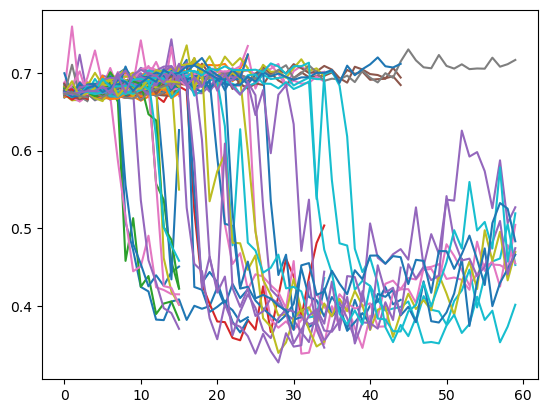

In [57]:
dfs = {result.log_dir: result.metrics_dataframe for result in results}
[d.val_loss.plot() for d in dfs.values()]

In [128]:
best = None
min_ = 11

for t in results:
    m = t.metrics_dataframe.val_loss.min()
    if min_ > m:
        min_ = m
        best = t

<Axes: >

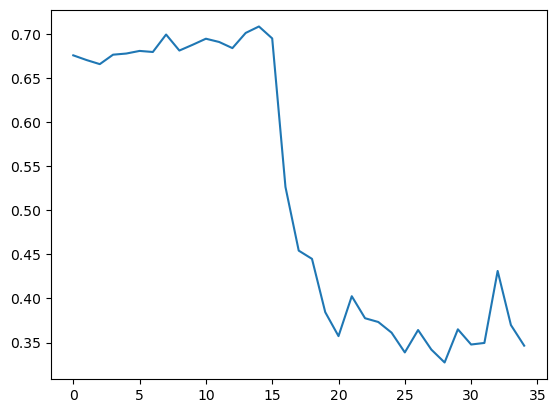

In [131]:
best.metrics_dataframe.val_loss.plot()

In [134]:
best.metrics['experiment_tag']

'834_batch_size=16,dropout=0.5000,epoch_number=35,hidden_dim=512'

In [138]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True)

In [142]:
torch.save(model, 'E:/Programming/DL_CurseWork/models/back.pth')

In [148]:
model = LSTMModel(
    embeding_m=model_w2v,
    hidden_dim=512,
    output_dim=2,
    n_layers=2,
    dropout=0.5
)

optimizer = optim.Adam(model.parameters())

criterion = nn.CrossEntropyLoss()

model = model.to('cuda')
criterion = criterion.to('cuda')

C:\Users\tiazz0\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [149]:
n_epochs = 28 + 1

for epoch in range(n_epochs):
    model.train()
    epoch_loss = 0
    for X_batch, y_batch in train_loader:
        predictions = model(X_batch.cuda())
        loss = criterion(predictions, y_batch.cuda())
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        epoch_loss += loss.item()
    
    with torch.no_grad():
        val_loss, val_acc = 0, 0
        for X_batch, y_batch in test_loader:
            predictions = model(X_batch.cuda())
            loss = criterion(predictions, y_batch.cuda()).item()
            acc = accuracy_score(y_batch, predictions.argmax(dim=1).cpu().detach()).item()
            val_loss += loss
            val_acc += acc
      
    if epoch % 2 == 0:
      print(f'#{epoch} Training loss: {epoch_loss / len(train_loader)} val_loss: {val_loss / len(test_loader)}')
    

#0 Training loss: 0.6769307116982798 val_loss: 0.6696794629096985
#2 Training loss: 0.6669191035328719 val_loss: 0.67168128490448
#4 Training loss: 0.6578714484890933 val_loss: 0.6729620695114136
#6 Training loss: 0.6514203444359794 val_loss: 0.6869218349456787
#8 Training loss: 0.6503283532838973 val_loss: 0.6785816550254822
#10 Training loss: 0.6508760837020067 val_loss: 0.7011358141899109
#12 Training loss: 0.6500380127518265 val_loss: 0.6966924071311951
#14 Training loss: 0.6488031874258051 val_loss: 0.7187262773513794
#16 Training loss: 0.593966223733135 val_loss: 0.48515579104423523
#18 Training loss: 0.38986645315690016 val_loss: 0.42558538913726807
#20 Training loss: 0.3561793826717548 val_loss: 0.38567933440208435
#22 Training loss: 0.3074768580417469 val_loss: 0.4164569079875946
#24 Training loss: 0.28334414842661726 val_loss: 0.3906494975090027
#26 Training loss: 0.26490157454338653 val_loss: 0.3471037447452545
#28 Training loss: 0.24953025417826163 val_loss: 0.3456097543239

In [150]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=True)
X_batch, y_batch = next(iter(test_loader))
predictions = model(X_batch.cuda()).argmax(dim=1).cpu().detach()
print(classification_report(y_batch, predictions))

              precision    recall  f1-score   support

           0       0.83      0.84      0.84       295
           1       0.90      0.89      0.90       461

    accuracy                           0.87       756
   macro avg       0.87      0.87      0.87       756
weighted avg       0.87      0.87      0.87       756



In [152]:
torch.save(model, 'E:\Programming\DL_CurseWork\models/bf084f090.pth')

In [155]:
review = 'отзыв о кафе грейс: К сожалению, наш поход в данное заведение нам совершенно не понравился. Уже с самого начала все незаладилось, после того, как нас 20 минут не могли посадить и еще столько же принять заказ. Прождав 30 минут, мы сами взяли кофе со стойки и шарлотку, которая оказалась сухой. Единственное, нужно отдать должное менеджер пытался координировать персонал, но это особо не помогало. Организации абсолютно не было, что испортило наш визит'
model.eval()
x = train_dataset.vectorize(review).unsqueeze(0)
predictions = model(x).argmax(dim=1).cpu().detach()
print(predictions)

tensor([0])


In [156]:
review = 'отзыв о кафе грейс: наш поход в данное заведение нам совершенно понравился'
model.eval()
x = train_dataset.vectorize(review).unsqueeze(0)
predictions = model(x).argmax(dim=1).cpu().detach()
print(predictions)

tensor([1])
